In [1]:
from google.colab import files
uploaded = files.upload()

Saving SAB.csv to SAB.csv


# 1. Import một số thư viện cần thiết


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
#2 Đọc dữ liệu từ tệp CSV
df = pd.read_csv('SAB.csv')
#3. Xử lý dữ liệu
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df=df.reset_index(drop=True)


#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 7:3

In [3]:
train_size = int(0.7 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [4]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [5]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[61277.07841021059, 55498.65022276794, 59213.33274914051, 61684.8887459492, 57971.00713106029, 67440.93630654518, 68930.23705834514, 63769.4968540527, 55618.209502966565, 65359.59615763905, 61037.570564337766, 59252.976301380695, 62473.74347009546, 64152.41690655246, 65235.87605421149, 59531.12601414947, 60602.529705692614, 64450.20082744536, 59661.391819091965, 69853.95752799284, 63008.84348348916, 64053.669119640566, 60564.373733816545, 64858.83024169166, 61356.073138615095, 57305.79197468157, 59307.39849551104, 59107.62558891451, 62403.289988977514, 59504.63254485761, 64722.76342939745, 63064.6278762834, 62158.63526043309, 60485.02048556082, 61374.938128236885, 62044.49911743241, 64181.310831147355, 57457.46218232595, 59037.01985700287, 60026.4339247176, 57194.29320993552, 60833.01855839797, 58715.27135663234, 57289.693786591146, 68981.45720530025, 59327.227482940645, 62292.26979935717, 51924.916319555814, 62303.81041029481, 59125.28662

#7. Tính RMSE, MSE, MAPE

In [6]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 29301.53625808594
Testing MAE: 24257.740074683385
Testing MAPE: 38.113495493285185


#8. Vẽ mô hình dự báo

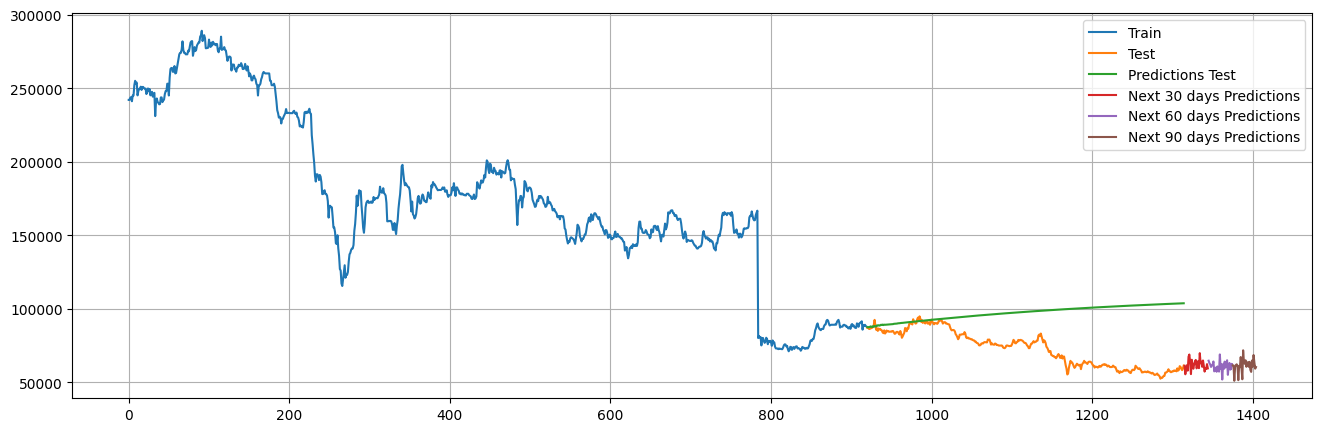

In [7]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()

#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 8:2

In [8]:
train_size = int(0.8 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [9]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [10]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[64012.13673084702, 62067.018084231306, 66053.1303915922, 55916.193977644994, 66446.015638254, 62757.035532630754, 55505.423906232754, 68845.08016357965, 68099.30546949545, 56626.50877380268, 61195.37265749309, 56067.30583871374, 62362.13112303017, 62793.78771322001, 55154.33185331584, 65356.61093847059, 60593.218853401675, 60727.74295615161, 62367.405986503596, 63771.7872121417, 61465.95270479522, 63120.745060447036, 58835.882217271064, 62282.44536987579, 59342.58783431203, 56577.290914531244, 66769.79782130143, 61070.49869027559, 63265.65877017894, 62952.56247275523, 63428.58685590404, 72405.74593211678, 63450.448604790996, 62110.09044245886, 68010.18271925377, 67692.84870669474, 55582.50975227442, 59067.866066110335, 61119.490956690795, 57285.38129402512, 61604.386282090425, 58278.422564774824, 60067.42570926293, 57449.208637104704, 63655.60375201798, 65921.60184222565, 62612.88383857811, 60758.58900555187, 66351.18450535423, 60472.6953

#7. Tính RMSE, MSE, MAPE

In [11]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 20362.235759827676
Testing MAE: 17228.470662777177
Testing MAPE: 28.581459867555786


#8. Vẽ mô hình dự báo

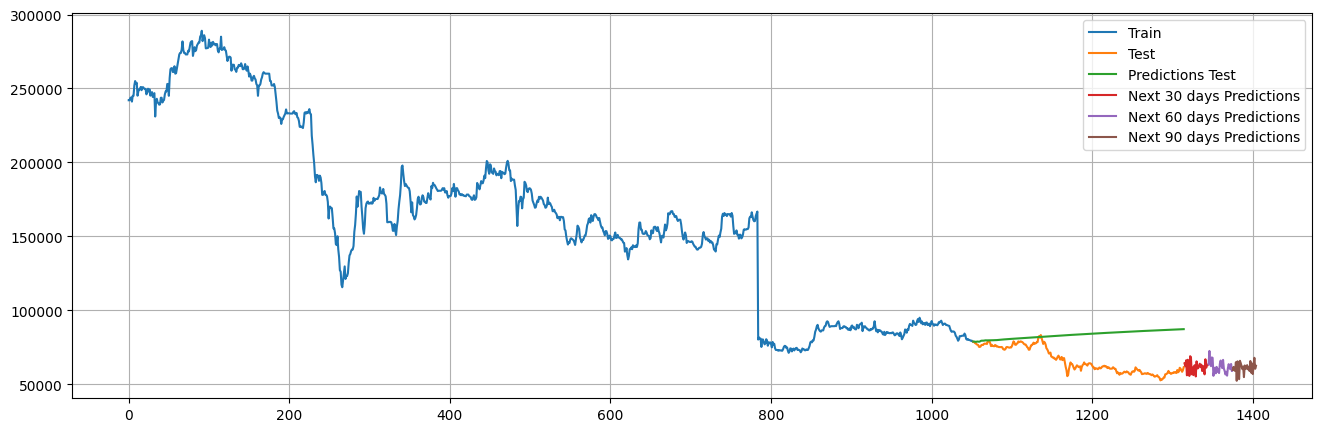

In [12]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()

#4. Phân chia dữ liệu thành tập huấn luyện, kiểm tra  theo tỉ lệ 9:1

In [13]:
train_size = int(0.9 * len(df))
test_size =  len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

#5. tìm số lượng lag phù hợp cho mô hình

In [14]:
#pacf= plot_pacf(df['Price'],lags=25)
#acf= plot_acf(df['Price'],lags=25)
# Sử dụng AIC để tìm lag tốt nhất
aic_values = []
max_lag = 30  # Chọn tối đa độ trễ muốn kiểm tra

for lag in range(1, max_lag + 1):
    model = AutoReg(train_data["Price"], lags=lag).fit()
    aic_values.append(model.aic)

best_lag = np.argmin(aic_values) + 1
print(f'Lag tốt nhất theo AIC: {best_lag}')


Lag tốt nhất theo AIC: 30


#6. Dự đoán giá trong 90 ngày tới

In [15]:

# Huấn luyện mô hình AR trên tập huấn luyện
ar_model = AutoReg(train_data['Price'], lags=best_lag)
ar_model_fit = ar_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Dự đoán phần dư sử dụng mô hình AR
pred_errors = ar_model_fit.resid

# Tính toán các tham số của dự báo
mu = pred_errors.mean()
sigma = pred_errors.std()

# Dự đoán giá cho 90 ngày tiếp theo
future_forecasts = []
for i in range(90):
    future_error = np.random.normal(loc=mu, scale=sigma)
    future_forecast = test_data['Price'].iloc[-1] + future_error
    future_forecasts.append(future_forecast)

# Hiển thị kết quả
print('Predicted closing prices for the next 90 days:')
print(future_forecasts)


Predicted closing prices for the next 90 days:
[64882.9286349832, 62752.47043122018, 63180.97341736245, 71818.58318580448, 56369.17042320602, 65270.289437421445, 58275.67780182238, 59064.97261516233, 63544.891297099326, 65900.746188856, 66439.89951353651, 60743.983678162804, 65954.77637424432, 62632.83123248844, 59608.94617877935, 57886.44320206567, 65542.03721152125, 58711.415257811794, 70302.78655178662, 62549.71365725888, 65141.956735714484, 64875.8790826895, 66262.72159422816, 60837.94622280666, 60317.13205758897, 62197.52779083957, 57180.31245713995, 60247.43008890085, 57315.84539247644, 62663.29740327716, 54903.87686535112, 59501.753471174074, 59699.54537153565, 57538.3096050648, 66286.78916681035, 66571.46749577859, 59923.96845633464, 59685.89339332049, 61352.988261616796, 58039.219997632186, 65186.79383345488, 55145.030286150446, 68091.08375579628, 61899.9819188831, 64682.6422811354, 67520.18396921676, 61992.48356062258, 63832.56389441572, 51718.89770975754, 60746.09368511612, 

#7. Tính RMSE, MSE, MAPE

In [16]:
y_test = test_data['Price'].values
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Testing RMSE: 5656.462257847032
Testing MAE: 4841.45486303095
Testing MAPE: 8.451456555602181


#8. Vẽ mô hình dự báo

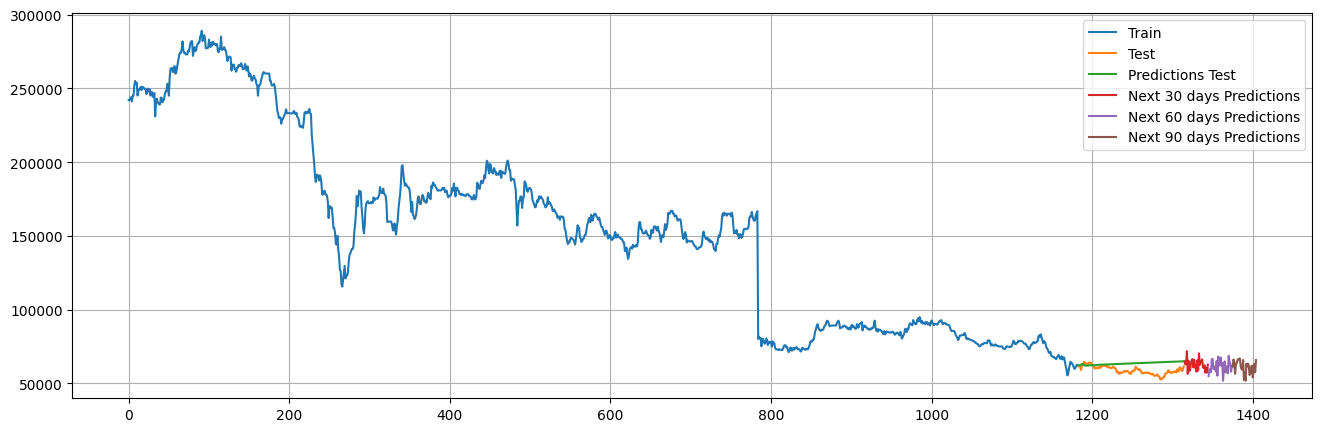

In [17]:
# Chia future_forecasts thành 30 ngày, 60 ngày và 90 ngày
predictions_30_days = future_forecasts[:30]
predictions_60_days = future_forecasts[:60]
predictions_90_days = future_forecasts[:90]

# Vẽ biểu đồ
plt.figure(figsize=(16, 5))
plt.grid(True)
plt.plot(train_data.index, train_data['Price'], label='Train')
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_pred, label='Predictions Test')

# Vẽ dự báo của 30 ngày, 60 ngày và 90 ngày tiếp theo
forecast_index_30 = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
forecast_index_60 = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
forecast_index_90 = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(forecast_index_30, predictions_30_days, label='Next 30 days Predictions')
plt.plot(forecast_index_60, predictions_60_days[30:], label='Next 60 days Predictions')
plt.plot(forecast_index_90, predictions_90_days[60:], label='Next 90 days Predictions')
plt.legend()
plt.show()